# Lecture 28 - Numerical Solutions of First-Order Systems

## Overview, Objectives, and Key Terms
 
This lesson is a direct extension of [Lecture 27](ME400_Lecture_27.ipynb), in which the focus was the numerical solution of first-order IVPs.  Here, those techniques are extended to *systems* of first-order equations.

### Objectives

By the end of this lesson, you should be able to

- Set up and solve simple linear systems *numerically* using NumPy.
- Solve systems of first-order IVPs numerically using forward and backward Euler's method
- Solve systems of first-order IVPs using `odeint`

### Prerequisites

You should already be able to

- Solve IVPs using Euler's method based on the material of [Lecture 27](ME400_Lecture_27.ipynb)
- Define one- and two-dimensional arrays using NumPy arrays based on the material of [Lecture 4](ME400_Lecture_4.ipynb).  
- Use `np.linalg.solve` to solve $\mathbf{Ax = b}$ based on the material of [Lecture 4](ME400_Lecture_4.ipynb).

Please review these topics (and resources) as needed.

### Key Terms



## A Coupled System and Its Numerical Solution

[finite-diff]: ME400_Lecture_21.ipynb
[sym-odes]: ME400_Lecture_26.ipynb
[num-1st-order]: ME400_Lecture_27.ipynb


Let's motivate the discussion with the familiar [spring-mass system][sym-odes]:

$$
   m \frac{d^2 x}{dt^2} = -k x - a \frac{dx}{dt} \, ,
$$

subject to subject to the ICs $x(0) = x_0$ and $x'(0) = v_0$.   This equation can be solved directly as a second-order equation using standard techniques or by using SymPy.  It would also be possible to solve this *numerically* by applying the appropriate [finite-difference approximations][finite-diff] to both $d^x/dt^2$ and $dx/dt$.  There are a variety of ways to do this (we have more than one way to approximate $y'$ for instance), and each would be somewhat more complicated than the Euler methods [previously discussed][num-1st-order].

Instead, we *reduce* the second-order problem to a *system* of two first-order problems.  Let 

$$
   \frac{dx}{dt} = v(t) 
$$

from which we have

$$
  \frac{dv}{dt} = -\frac{kx(t) + av(t)}{m} \, .
$$

These two equations can be written more compactly in matrix form:

$$
\left [ \begin{array}{c}
  v' \\
  x' 
\end{array} \right ]
= 
\left [ \begin{array}{cc}
  -\frac{a}{m} & -\frac{k}{m} \\
   1   &  0 \\
\end{array} \right ]
\left [ \begin{array}{c}
  v(t) \\
  x(t)
\end{array} \right ]
$$

or 

$$
  \mathbf{y}' = \mathbf{A}\mathbf{y}(t) \, ,
$$

where  $\mathbf{y} = [v(t), x(t)]^T$ and $T$ is the transpose.

By writing the system in this form, it can be observed to follow the more general form 

$$
    \mathbf{y}' = \mathbf{f}(t, \mathbf{y}(t)) \, ,
$$

for which the *forward Euler method* is defined as

$$
    \mathbf{y}(t_{n+1}) = \mathbf{y}(t_n) + \Delta \mathbf{f}(t, \mathbf{y}(t_n)) \, ,
$$

where $t_{n+1} = t_{n} + \Delta$.  The simplicity of forward Euler is obvious here: no matter how complicated $\mathbf{f}$ might be, all we need to do is evaluate it once using information defined at the old time $t_n$ to determine the solution at the new time $t_{n+1}$.  It's *explicit*.  We do *not* need to solve any linear or nonlinear systems.  For the case of the spring-mass systems, that step looks like

$$
    \mathbf{y}(t_{n+1}) = \mathbf{y}(t_n) + \Delta \mathbf{A} \mathbf{y}(t_n) \, .
$$

***

**Exercise**:  Consider the spring-mass system.  For $m = 1$, $k = 1$, $a = 1$, $x(0) = 0$, and $v(0) = 1$, compute $x(t)$ at $t = [0, 0.5, 1.0, \ldots, 10]$ (that's 21 times) using forward Euler.  Plot these estimates and the actual solution.

*Solution*:  First, let's get the reference solution using SymPy in the form of a callable, lambdified function.  For completeness, return both $x(t)$ and $v(t)$:

In [1]:
def spring_mass_reference(m, k, a, x_0, v_0):
    # set up symbols
    import sympy as sy
    x, t = sy.symbols('x t')
    # set up/solve IVP
    ivp = sy.Eq(m*sy.diff(x(t), t, 2), -k*x(t) - a*sy.diff(x(t), t))
    sol = sy.dsolve(ivp)
    # set up/solve ICs
    ic1 = sy.Eq(sol.rhs.subs(t, 0), x_0)
    ic2 = sy.Eq(sy.diff(sol.rhs, t, 1).subs(t, 0), v_0)
    coefs = sy.solve([ic1, ic2], [sy.Symbol('C1'), sy.Symbol('C2')])
    # make substitutions and return the lambdified results
    sol_x = sol.rhs.subs(coefs).simplify()
    sol_v = sy.diff(sol_x, t)
    f_x = sy.lambdify(t, sol_x)
    f_v = sy.lambdify(t, sol_v)
    return f_v, f_x

Now, apply forward Euler.

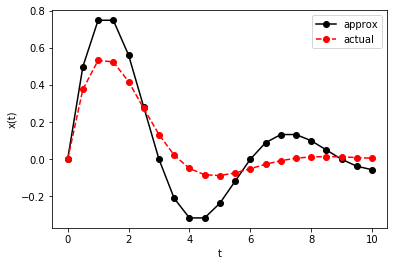

In [2]:
import numpy as np
# Define givens
m, k, a, x0, v0 = 1, 1, 1, 0, 1
# Define the times
t = np.linspace(0, 10, 21)
# Define the solution and set the ICs
y_fe = np.zeros((len(t), 2))
y_fe[0, 0] = v0
y_fe[0, 1] = x0
# Define the 2 by 2 matrix A.  Note the spacing
# used to enhance readability.
A = np.array([[-a/m, -k/m],
              [1,    0   ]]) 
# Define the time step
Delta = t[1] - t[0]
# Now, loop through for each time step
for i in range(0, len(t)-1):
    y_fe[i+1] = y_fe[i] + Delta*A.dot(y_fe[i])
# Extract v and x.  
v_fe, x_fe = y_fe[:, 0], y_fe[:, 1]
# Get the reference values (as functions)
v_ref, x_ref = spring_mass_reference(m, k, a, x0, v0)
# Plot
import matplotlib.pyplot as plt
plt.plot(t, x_fe, 'k-o', t, x_ref(t), 'r--o')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend(['approx', 'actual'])
plt.show()

***

**Exercise**: This numerical solution for the spring-mass equation above is qualitatively close to the reference found using SymPy, but it's quantitatively far enough away that I'm suspicious.  Compute the absolute error in $x(10)$ as a function of $\Delta$.  Does it converge?

***

**Exercise**: An important phenomenon in nuclear reactors is the production of ${}^{135}$Xe, a substance that is really good at absorbing the neutrons needed to sustain the chain reaction that powers such reactors. ${}^{135}$Xe is produced directly from fission, but it is also generated from the decay of ${}^{135}$I, another nuclide produced by fission.  Details aside, the concentrations of these nuclides is well modeled by the following system of equations:

$$
  \frac{d N_{I}}{dt} = \gamma_{I} \Sigma_f \phi - \lambda_I N_I(t) \, ,
$$

and

$$
  \frac{d N_{Xe}}{dt} = \gamma_{Xe} \Sigma_f \phi + \lambda_I N_I(t) - \sigma_a^{Xe} N_{Xe}(t) \phi +  \lambda_{Xe} N_{Xe}(t) \, .
$$

 


Suppose that $\sigma_a^{Xe} = 3.5 \times 10^{-18}$ cm$^2$, $\gamma_{Xe} = 0.006$, $\gamma_I = 0.064$, $\lambda_{Xe} = 2.95\times 10^{-5}$ 1/s, and $\lambda_{I} = 2.1\times 10^{-5}$ 1/s, and $\Sigma_f = 0.1$ 1/cm. s.

  1. If  $\phi$ has units of 1/cm$^2$, what is the unit of $N_I$ and $N_{Xe}$?
  2. Find the steady-state (i.e., equilibrium) value of $N_I$ and $N_{Xe}$ when $\phi = 10^{14}$ 1/cm$^2$.  Remember, steady state means "constant in time." Hence, set the derivatives to zero, and solve for $N^{SS}_I$ and $N^{SS}_{Xe}$. 
  3. Use those steady-state values $N^{SS}_I$ and $N^{SS}_{Xe}$ as the initial condition for the IVP at $t = 0$.  Solve the equations using forward Euler for $\phi = 10^{13}$ 1/cm$^2$, $\phi = 10^{14}$ 1/cm$^2$, and $\phi = 2\times 10^{14}$ 1/cm$^2$ for times up 24 *hours*.  (Be careful about the step size you use.) 
  
***

## When the Equations are "Stiff"

A system of IVPs is considered "stiff" when the underlying time constants vary by several orders of magnitude.  That means one part of the solution (one nuclide, or the position of one mass in a spring-mass system) may grow or decay exponentially over periods of seconds, whereas some other part of the solution may vary over much smaller time periods, e.g., ms or smaller.  Forward Euler fails for these systems unless $\Delta$ is very, very small.  Sometimes, it must be small enough that solving the system becomes impractical.  

An alternative is to use methods that are implicit in time.  The chief example is backward Euler.  Remember, implicit here means the solution at $t_{n+1}$ depends on information at $t_{n+1}$, not $t_{n}$.  For systems of IVPs, we need to solve a matrix system to make the step.  For nonlinear IVPs, we need to solve a nonlinear equation (perhaps a system) to make the step.

Let's go back to the generic equation

$$
    \mathbf{y}' = \mathbf{f}(t, \mathbf{y}(t)) \, .
$$

Application of backward Euler gives

$$
    \mathbf{y}(t_{n+1}) = \mathbf{y}(t_n) + \Delta \mathbf{f}(t_{n+1}, \mathbf{y}(t_{n+1})) \, 
$$

where, again, $t_{n+1} = t_{n} + \Delta$.  For the case of the spring-mass systems, this backward-Euler step looks like

$$
    \mathbf{y}(t_{n+1}) = \mathbf{y}(t_n) + \Delta \mathbf{A} \mathbf{y}(t_{n+1}) \, .
$$

Note that $\mathbf{y}(t_{n+1})$ is on *both* sides of the equation.  To isolate it, we move the right-most term to the left-hand side, which leads to

$$
    (\mathbf{I} - \Delta \mathbf{A}) \mathbf{y}(t_{n+1}) = \mathbf{y}(t_n)  \, .
$$

This is a linear equation of the form $\mathbf{Mx}=\mathbf{b}$, and we can use `numpy.linalg.solve` to solve such systems.  

***

**Exercise**:  Solve the system $x + 2y = 3$ and $2x - y = 2$ for $x$ and $y$ using `numpy`.

*Solution*:  First, recognize this is the same as the matrix equation


$$
\left [ \begin{array}{cc}
   1 & 2 \\
   2 & -1 \\
\end{array} \right ]
\left [ \begin{array}{c}
  x \\
  y
\end{array} \right ] =
\left [ \begin{array}{c}
  3 \\
  2 
\end{array} \right ]
$$

Then, set up this matrix and vector using `numpy` arrays, and solve using `numpy.linalg.solve`:

In [3]:
M = np.array([[1,  2],
              [2, -1]])
b = np.array([3, 2])
v = np.linalg.solve(M, b)
x, y = v
x, y

(1.3999999999999999, 0.80000000000000004)

One can also check the answer makes sense.  Here, we should get $\mathbf{b}$ from the matrix-vector product $\mathbf{Mv}$:

In [4]:
M.dot(v)

array([ 3.,  2.])

***

**Example** Solve the spring-mass example from above using backward Euler.

*Solution*:

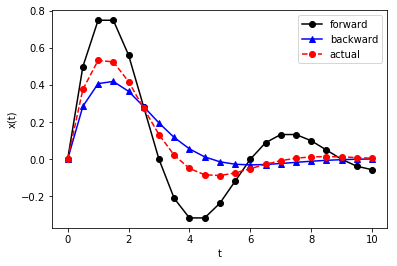

In [5]:
# We already have all the values set.  We'll 
# make a new solution array to compare BE to
# FE and the reference.

# Define the solution and set the ICs
y_be = np.zeros((len(t), 2))
y_be [0, 0] = v0
y_be [0, 1] = x0

# Make the 2x2 identity
I = np.eye(2)

# Now, loop through for each time step
for i in range(0, len(t)-1):
    y_be[i+1] = np.linalg.solve(I-Delta*A, y_be[i])
    
# Extract v and x.  
v_be, x_be = y_be[:, 0], y_be[:, 1]

# Plot
plt.plot(t, x_fe, 'k-o', t, x_be, 'b-^', t, x_ref(t), 'r--o')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend(['forward', 'backward', 'actual'])
plt.show()

***

**Example**:  For $\Delta = 0.1$, compute $x(10)$ and $y(10)$ by solving the following system using (1) forward Euler and (2) backward Euler:

$$
\left [ \begin{array}{c}
  x' \\
  y' 
\end{array} \right ]
= 
\left [ \begin{array}{rr}
  -10   &  0.00 \\
   10   & -0.01 \\
\end{array} \right ]
\left [ \begin{array}{c}
  x(t) \\
  y(t)
\end{array} \right ]
+
\left [ \begin{array}{c}
  1 \\
  0
\end{array} \right ]
$$

for $x(0) = y(0) = 0$.  How do things change when $\Delta = 0.2$?  $\Delta = 0.001$?  

*Solution*:

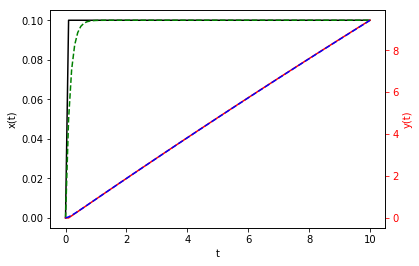

In [88]:
t = np.linspace(0, 10, 101)
z_fe = np.zeros((len(t), 2))
z_be = np.zeros((len(t), 2))
A = np.array([[-10,  0.00],
              [10,  -0.01]])
s = np.array([1, 0])
I = np.eye(2)
Delta = t[1]-t[0]
for i in range(0, len(t)-1):
    z_fe[i+1] = z_fe[i] + Delta*(A.dot(z_fe[i]) + s)
    z_be[i+1] = np.linalg.solve(I-Delta*A, z_be[i] + Delta*s)
    
fig, ax1 = plt.subplots()
ax1.plot(t, z_fe[:, 0], 'k', t, z_be[:, 0], 'g--')
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)', color='k')
ax1.tick_params('y', colors='k')
ax2 = ax1.twinx()
ax2.plot(t, z_fe[:, 1], 'r', t, z_be[:, 1], 'b--')
ax2.set_ylabel('y(t)', color='r')
ax2.tick_params('y', colors='r')
plt.show()

## Back to `odeint`

While the Euler methods are proven and simple techniques for solving systems of first-order IVPs, routine analysis is best performed using more robust methods like those implemented in `odeint`.  As was shown in [Lecture 27](ME400_Lecture_27.ipynb), the basic ingredients needed to solve an IVP with `odeint` are a function that represents $y'$, the times at which $y(t)$ is to be evaluated, and the initial conditions.  The same goes for systems, and the procedure is illustrated by the following solved exercise.

***

**Exercise**:  Solve
    
$$
\left [ \begin{array}{c}
  x' \\
  y' 
\end{array} \right ]
= 
\left [ \begin{array}{rr}
  -10   &  0.00 \\
   10   & -0.01 \\
\end{array} \right ]
\left [ \begin{array}{c}
  x(t) \\
  y(t)
\end{array} \right ]
+
\left [ \begin{array}{c}
  1 \\
  0
\end{array} \right ]
$$

for $x(0) =  y(0) = 0$ and $t \in [0, 10]$ using `odeint` fo

*Solution*: First, import `odeint`:

In [48]:
from scipy.integrate import odeint

Then, define the derivative function.  Here, that's everything on the right-hand side of the original IVP.

In [90]:
def derivative(z, t):
    """ Evaluate the right-hand side of the IVP.  Here, t 
        is the time at which things are evaluated, and 
        z = [x, y] is the solution at that time.
    """
    A = np.array([[-10, 0],
                  [10, -0.01]])
    z_prime = A.dot(z) + np.array([1, 0])
    return z_prime

Define the times and solve the problem:

In [91]:
t = np.linspace(0, 10, 100)
ic = [0, 0]
z = odeint(derivative, ic, t)

Finally, plot the result.

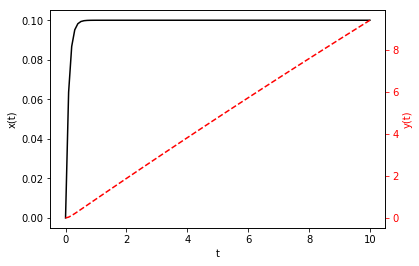

In [93]:
fig, ax1 = plt.subplots()
ax1.plot(t, z[:, 0], 'k-') # Note z[:, 0], NOT z[0, :]
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)', color='k')
ax1.tick_params('y', colors='k')
ax2 = ax1.twinx()
ax2.plot(t, z[:, 1], 'r--')
ax2.set_ylabel('y(t)', color='r')
ax2.tick_params('y', colors='r')
plt.show()

***

Consider the second-order equation for damped, harmonic motion:

$$
y'' + 2y'+2y=\sin(2x)
$$

for $y(0)=0$ and $y'(0)=0.5$.  Solve this using `odeint` for $t \in [0, 2\pi]$.

*Solution*:  This is second order, so we need to convert it first into a system of first-order equations.  Let $y' = v$.   Then, $v' = \sin(2x) - 2v - 2y$. Now, implement this as a derivative function:

In [107]:
def derivative(z, x):
    y, v = z  # unpacking and computing
    yp = v    # y' and v' separately
    vp = np.sin(2*x) - 2*v - 2*y 
    return [yp, vp] # lists are fine

Set the times, ICs, and solve:

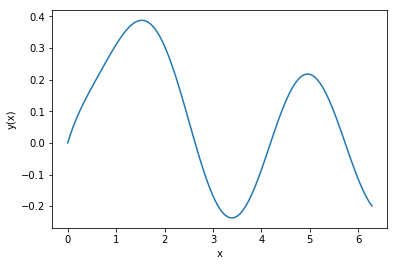

In [108]:
x = np.linspace(0, 2*np.pi, 100)
ic = [0, 0.5]
# this is another way to get the individual
# solution components:
y, v = odeint(derivative, ic, x).T
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y(x)')
plt.show()

## Further Reading

Make sure you know how to use `odeint` for single equations and systems of equations.  A good resource to supplement this lesson is the documentation and any examples include therein.